In [1]:
import pandas as pd
from dendropy import Tree
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
from utils import setup_plotting_standards, basic_formatting, mm
import seaborn as sns
from scipy.stats import gaussian_kde
import numpy as np

setup_plotting_standards()
COLOR = '#343434'

color_map = {
    "Zambia" : "#009E73", # green
    "Mozambique" : "#56B4E9", # blue
    "Nigeria" : "#0072B2",  # reddish-purple
    "Cameroon" : "#D55E00", # brown 
    "Democratic Republic of the Congo" : COLOR, #Black
    "Uganda" : "#F0E442",
    "Malawi" : "#E69F00", # orange 
    "Other" : "#C8C8C8" # grey
}

countries = ["Nigeria", "Cameroon", "Democratic Republic of the Congo", "Uganda", "Zambia", "Malawi", "Mozambique"]

In [2]:
md = list()
for file in ["supplemental_data1.csv", "supplemental_data2.csv"]:
    df = pd.read_csv( "../data/" + file, usecols=["taxa", "country", "collection_date", "included_analysis"] )
    df["workshop"] = (file == "supplemental_data1.csv")
    md.append( df )
    
md = pd.concat( md )
md = md.loc[md["included_analysis"]]

country_dict = dict()
for country in countries:
    country_dict[country] = md.loc[(md["country"]==country)&md["workshop"],"taxa"].to_list()

In [3]:
results = pd.read_csv( "population-estimates/subs-site-per-country.csv" )
results_scaled = results.copy()
for k, v in country_dict.items():
	results_scaled[[k,f"{k}_random"]] = results_scaled[[k,f"{k}_random"]] / len( v )
results_scaled.head()

,tree,total_branch_length,Nigeria,Nigeria_random,Cameroon,Cameroon_random,Democratic Republic of the Congo,Democratic Republic of the Congo_random,Uganda,Uganda_random,Zambia,Zambia_random,Malawi,Malawi_random,Mozambique,Mozambique_random
0,0,0.001904,8.030363e-07,5.544126e-07,5.806910e-07,4.332746e-07,4.315888e-07,4.325521e-07,0.000001,6.857500e-07,2.418120e-07,4.284907e-07,3.362397e-07,5.250813e-07,5.393257e-07,6.807328e-07
1,1,0.001926,7.675422e-07,5.255294e-07,5.560058e-07,5.642145e-07,4.903333e-07,5.826969e-07,0.000001,2.308104e-07,2.315418e-07,4.886169e-07,3.931419e-07,4.145933e-07,5.356429e-07,3.695715e-07
2,2,0.001903,7.637227e-07,5.966720e-07,5.660475e-07,3.914064e-07,4.392563e-07,4.645921e-07,0.000001,6.813960e-07,2.547446e-07,4.713479e-07,4.110687e-07,3.684548e-07,5.466209e-07,5.499924e-07
3,3,0.001943,7.566957e-07,6.632621e-07,6.204833e-07,2.550144e-07,4.551436e-07,5.097060e-07,0.000001,9.795571e-07,2.416990e-07,5.276730e-07,3.959910e-07,6.164188e-07,5.051859e-07,7.468673e-07
4,4,0.001884,7.784195e-07,6.116848e-07,5.565524e-07,7.466462e-07,4.306985e-07,4.330452e-07,0.000001,6.280229e-07,2.268686e-07,4.246328e-07,3.968044e-07,4.291572e-07,4.535037e-07,6.022498e-07


In [4]:
plot_df = results_scaled[countries]
plot_df = plot_df.reindex( columns=plot_df.median().sort_values( ascending=False ).index )
plot_df = plot_df / 1e-6
plot_df.head()

,Uganda,Nigeria,Cameroon,Mozambique,Democratic Republic of the Congo,Malawi,Zambia
0,1.313827,0.803036,0.580691,0.539326,0.431589,0.336240,0.241812
1,1.366201,0.767542,0.556006,0.535643,0.490333,0.393142,0.231542
2,1.344425,0.763723,0.566048,0.546621,0.439256,0.411069,0.254745
3,1.460906,0.756696,0.620483,0.505186,0.455144,0.395991,0.241699
4,1.438491,0.778419,0.556552,0.453504,0.430698,0.396804,0.226869


In [5]:
all_results = pd.read_csv( "population-estimates/rarefaction_curve.csv" )
all_params = pd.read_csv( "population-estimates/rarefaction-model-fit.csv" )
all_params.groupby( "country" )["V"].describe( percentiles=[0.025, 0.5, 0.975] )
summary = all_results.groupby( ["location", "sequences"] )["introductions"].describe( percentiles=[0.025, 0.5, 0.975] )
params_summary = all_params.groupby( "country" )[["V", "Km"]].median()
countries = ["Nigeria", "Cameroon", "Democratic Republic of the Congo", "Uganda", "Zambia", "Malawi", "Mozambique"]

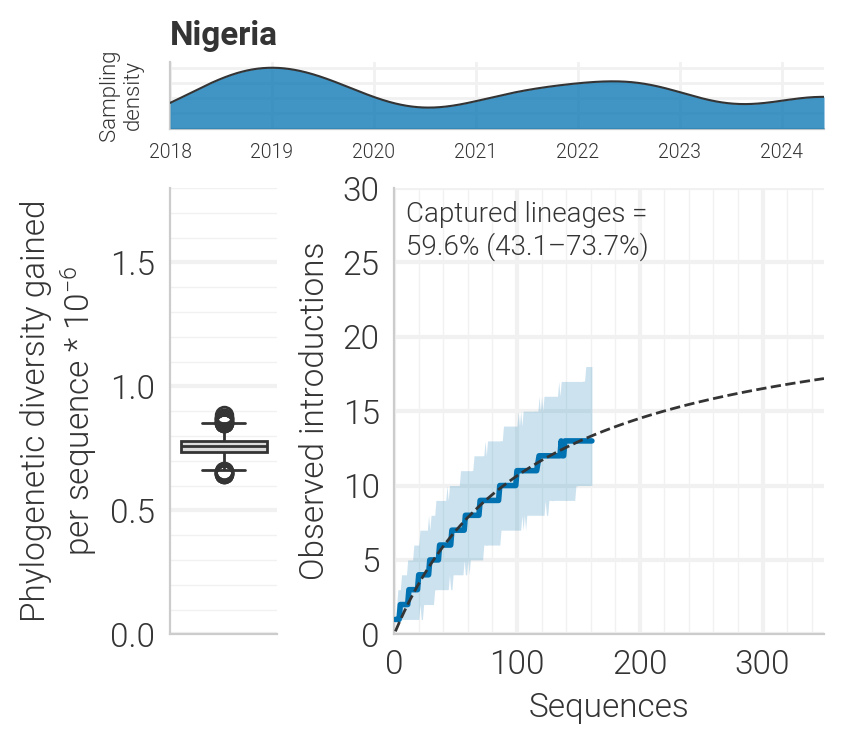

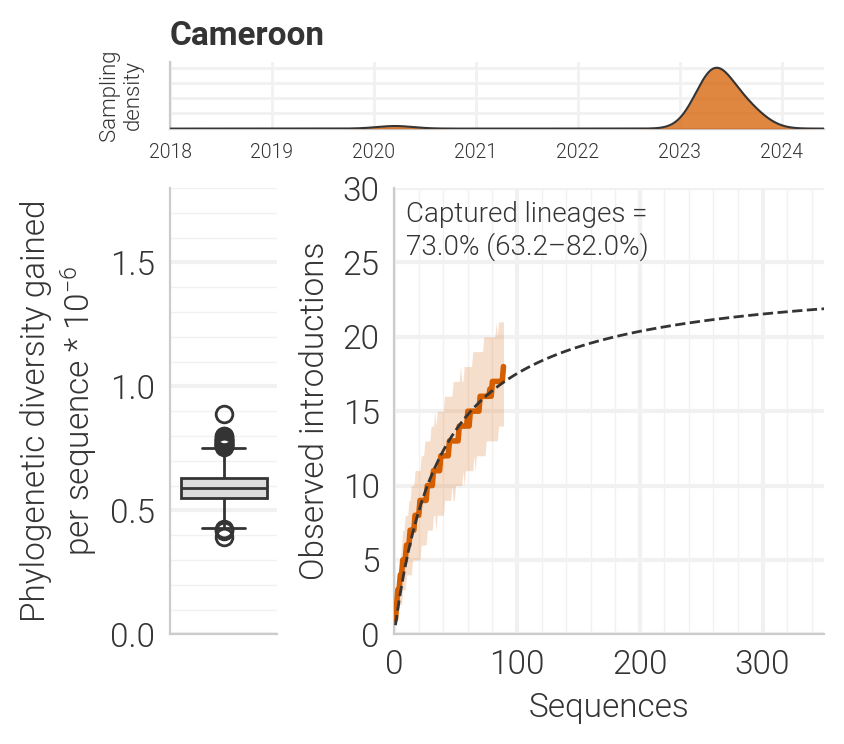

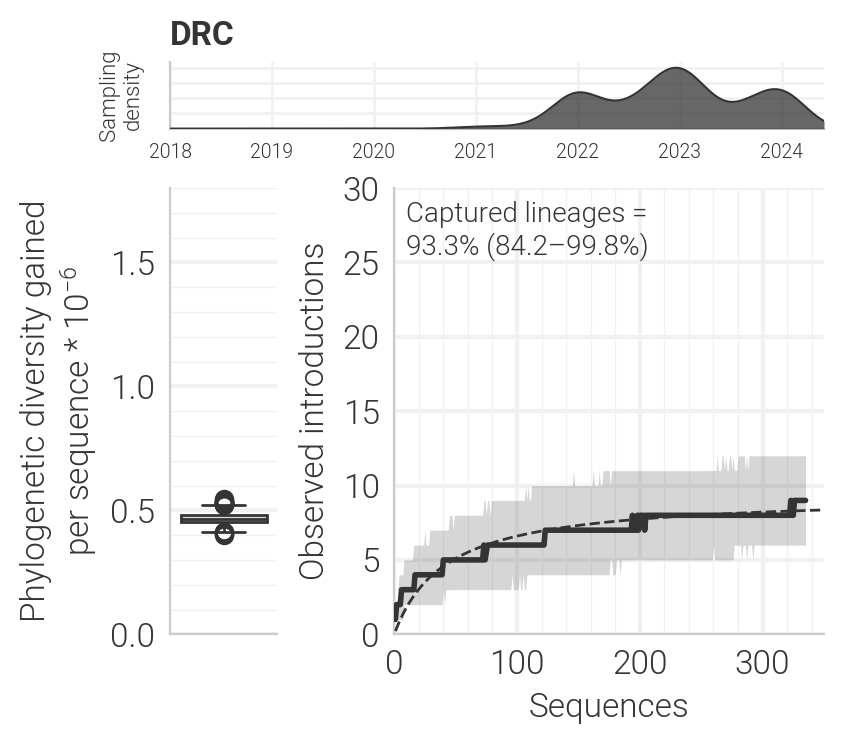

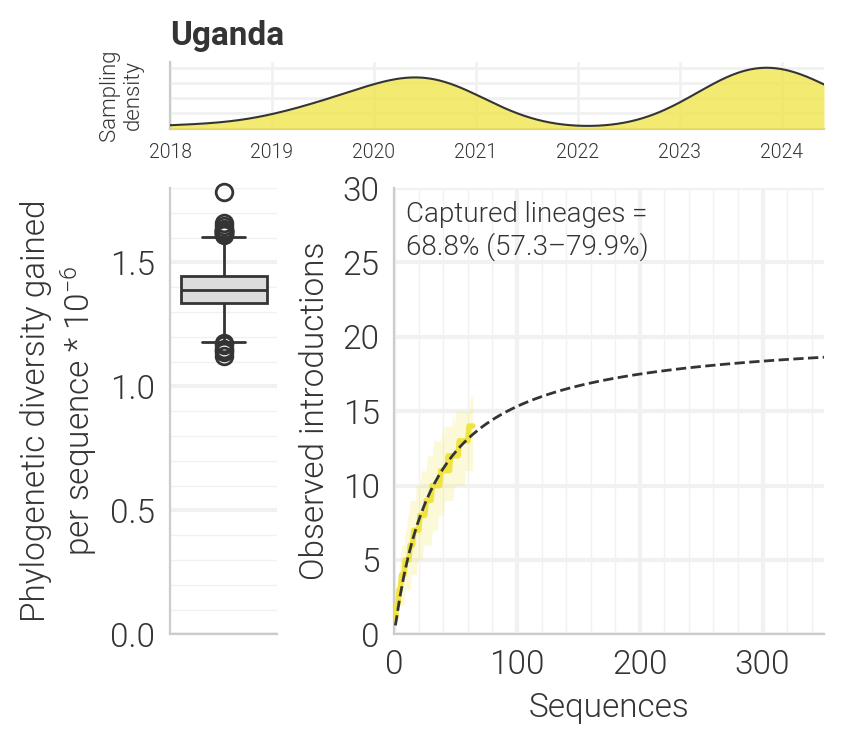

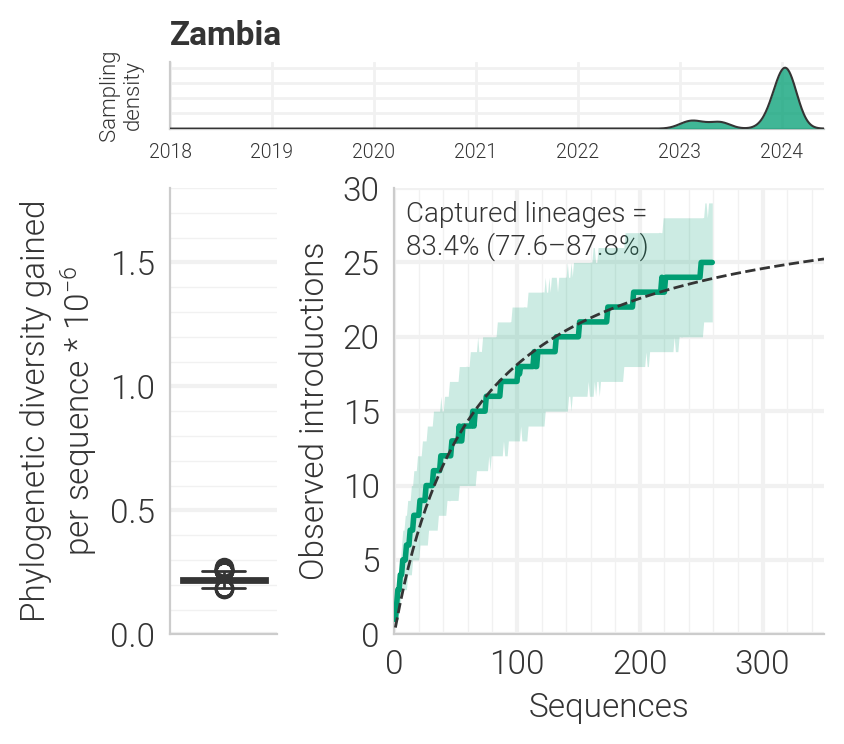

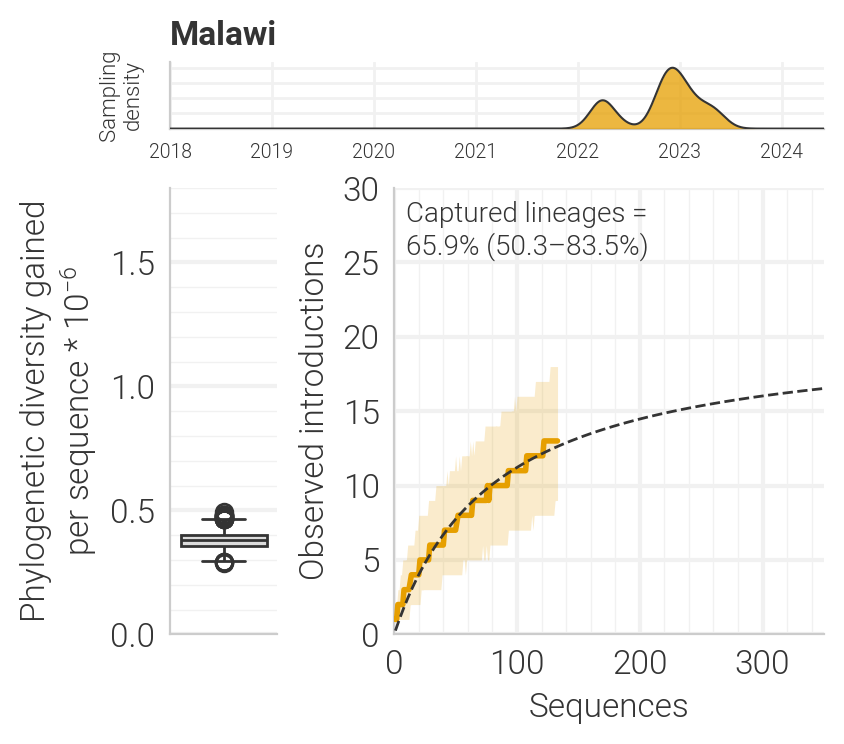

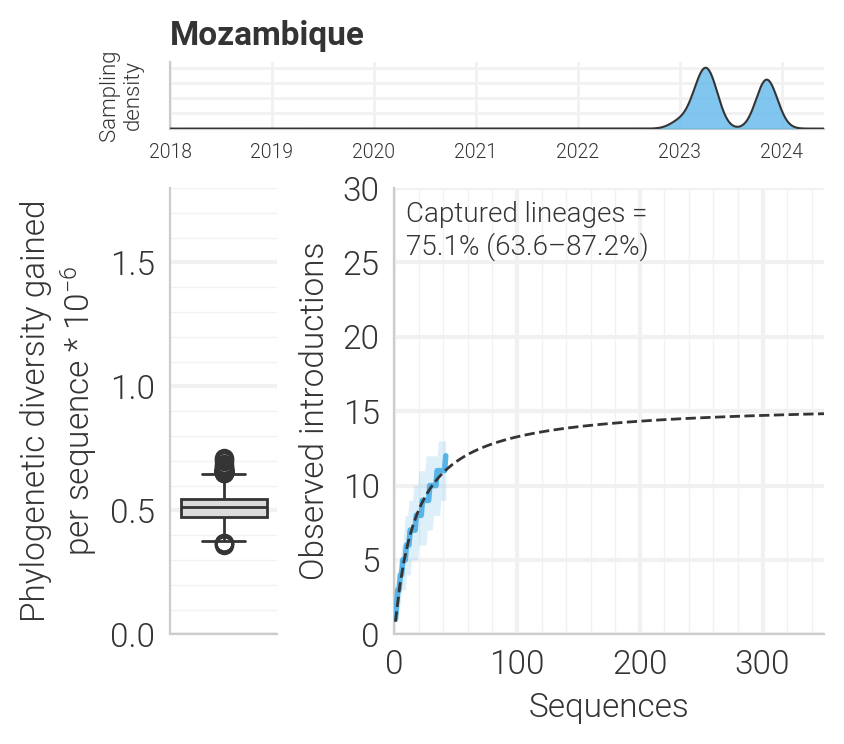

In [13]:
min_date = mdates.datestr2num( "2018-01-01" )
max_date = mdates.datestr2num( "2024-06-01" )

for country in countries:

    fig, axes = plt.subplots( dpi=200, figsize=(4.5,4), nrows=2, ncols=2, gridspec_kw={"height_ratios": [0.75,5], "width_ratios" : [1,4] } )
    gs = axes[0,0].get_gridspec()
    
    for ax in axes[0,:]:
        ax.remove()
        
    longax = fig.add_subplot(gs[0,:])
    
    #Sampling
    dates = mdates.date2num( md.loc[(md["country"]==country)&md["workshop"],"collection_date"] )
    date_kde = gaussian_kde( dates, bw_method=0.3 )
    x_grid = np.linspace( min_date, max_date, 1000)
    y_grid = date_kde.evaluate( x_grid )
    y_grid = y_grid / y_grid.max()
    longax.plot( x_grid, y_grid, color=COLOR, linewidth=0.75, zorder=50 )
    longax.fill_between( x_grid, [0], y_grid, color=color_map[country], linewidth=0, alpha=0.75, zorder=40 )
    longax.set_yticks([0,0.25,0.5,0.75,1], [] )
    
    basic_formatting(longax, which="both", ylabel="Sampling\ndensity", ylims=(0, 1.1), xlims=(mdates.datestr2num( "2017-12-31"), mdates.datestr2num( "2024-06-01" ) ), xsize=7, ysize=8) 
    
    longax.set_xticks(mdates.datestr2num([f"{x}-01-01" for x in range(2018,2025)] ), minor=False )
    longax.xaxis.set_minor_locator( mdates.YearLocator() )
    longax.xaxis.set_major_formatter( mdates.DateFormatter( "%Y" ) )
    
    ax = axes[1,0]
    #x=[idx]*plot_df.shape[0], y=plot_df[country], native_scale=True, color="gainsboro", linecolor=COLOR, linewidth=1, width=0.80
    bx = sns.boxplot( x=[0] * plot_df.shape[0], y=plot_df[country], native_scale=True, color="gainsboro", linecolor=COLOR, linewidth=1, width=0.80, ax=ax, flierprops={"clip_on" : False } )
    
    basic_formatting(ax, which="y", ylabel="Phylogenetic diversity gained\nper sequence * $\mathregular{10^{-6}}$", xlims=(-0.5, 0.5), ylims=(0, 1.75), xsize=11, ysize=12)
    ax.set_xticks([])
    ax.set_yticks( list( np.arange(0, 2.1, 0.1) ), minor=True )
    ax.set_yticks( list( np.arange(0, 1.8, 0.5) ), minor=False )
    ax.grid( which="major", axis="y", linewidth=1.5, color="#F1F1F1", zorder=1 )
    ax.grid( which="minor", axis="y", linewidth=0.5, color="#F1F1F1", zorder=1 )
    ax.set_ylim( 0, 1.8 )
        
    ax = axes[1,1]
    
    data = summary.loc[country].reset_index()
    points = ax.plot( "sequences", "50%", data=data, color=color_map[country], linewidth=2, linestyle="solid", zorder=100 )
    ax.fill_between( "sequences", "2.5%", "97.5%", data=data, color=color_map[country], alpha=0.2, linewidth=0, zorder=50 )
    x_grid = np.linspace( 1, 350, 100 )
    V = params_summary.loc[country]["V"]
    K = params_summary.loc[country]["Km"]
    y_grid = mm( x_grid, V, K )
    
    captured = all_params.loc[all_params["country"] == country, "percent_captured"].describe( percentiles=[0.025, 0.5, 0.975] )
    ax.plot( x_grid, y_grid, color=COLOR, linestyle="--", linewidth=1, zorder=110 )
    ax.text( 10, 25.5, f"Captured lineages =\n{captured['50%']:.1%} ({captured['2.5%'] * 100:.1f}–{captured['97.5%']:.1%})", fontsize=10, ha="left" )
    ax.set_xticks( [0, 100, 200, 300] )
    ax.set_xticks( range(0, 350, 20), minor=True )
    ax.set_yticks( [0, 5, 10, 15, 20, 25, 30] )
    #ax.set_yticks( range(0,30, 1), minor=True )
    basic_formatting( ax, which="both", xlims=(0, 350), ylims=(0, 30), xsize=12, ysize=12, xlabel="Sequences", ylabel="Observed introductions" )
    ax.grid( which="major", axis="both", linewidth=1.5, color="#F1F1F1", zorder=1 )
    ax.grid( which="minor", axis="both", linewidth=0.5, color="#F1F1F1", zorder=1 )

    shortname = country.replace( "Democratic Republic of the Congo", "DRC")
    
    longax.set_title( shortname, loc="left", color=COLOR, fontsize=12, fontweight="bold" )
    
    plt.tight_layout( h_pad=0.3, w_pad=0.5)
    plt.savefig( f"plots/figure4-surveillance-assessment-{shortname}.pdf")
    plt.show()
